## MLflow Tracking Quickstart

This notebook demonstrates using a local MLflow Tracking Server to log, register, and then download a model

In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns

import mlflow
from mlflow.models import infer_signature

import mlflow
import subprocess
import threading
import socket
import os
os.environ["GIT_PYTHON_REFRESH"] = "quiet"

### Set the MLflow Tracking URI 

Depending on where you are running this notebook, your configuration may vary for how you initialize the interface with the MLflow Tracking Server. 

For this example, we're using a locally running tracking server, but other options are available (The easiest is to use the free managed service within [Databricks Community Edition](https://community.cloud.databricks.com/)). 

Please see [the guide to running notebooks here](https://www.mlflow.org/docs/latest/getting-started/running-notebooks/index.html) for more information on setting the tracking server uri and configuring access to either managed or self-managed MLflow tracking servers.

In [2]:
# NOTE: review the links mentioned above for guidance on connecting to a managed tracking server, such as the free Databricks Community Edition
def start_mlflow_server():
    subprocess.run(["mlflow", "server", "--host", "0.0.0.0", "--port", "5000"])

server_thread = threading.Thread(target=start_mlflow_server)
server_thread.start()
import socket
hostname = socket.gethostname()
ip_address = socket.gethostbyname(hostname)

mlflow.set_tracking_uri(f"http://{ip_address}:5000")
print(f"MLflow tracking URI set to: http://{ip_address}:5000")

MLflow tracking URI set to: http://10.164.4.28:5000


## Read the data

Read the white wine quality and red wine quality CSV datasets and merge them into a single DataFrame.
Then Merge the two DataFrames into a single dataset, with a new binary feature "is_red" that indicates whether the wine is red or white.

In [3]:
import pandas as pd
white_wine = pd.read_csv("Data/winequality-white.csv", sep=";")
red_wine = pd.read_csv("Data/winequality-red.csv", sep=";")

red_wine['is_red'] = 1
white_wine['is_red'] = 0

data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [4]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


## Visualize data
Before training a model, explore the dataset using Seaborn and Matplotlib.

Plot a histogram of the dependent variable, quality.

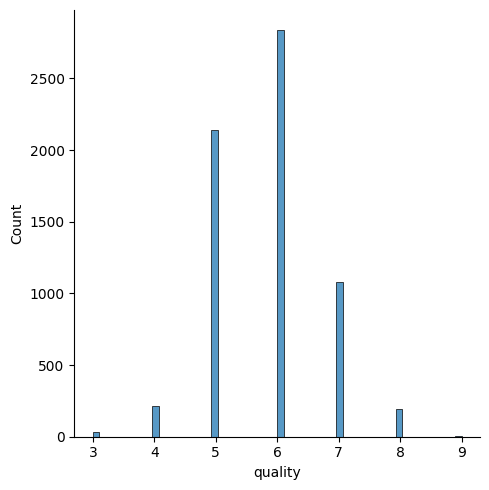

In [5]:
sns.displot(data.quality, kde=False)

Looks like quality scores are normally distributed between 3 and 9.

Define a wine as high quality if it has quality >= 7.

In [6]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

Box plots are useful for identifying correlations between features and a binary label. Create box plots for each feature to compare high-quality and low-quality wines. Significant differences in the box plots indicate good predictors of quality.

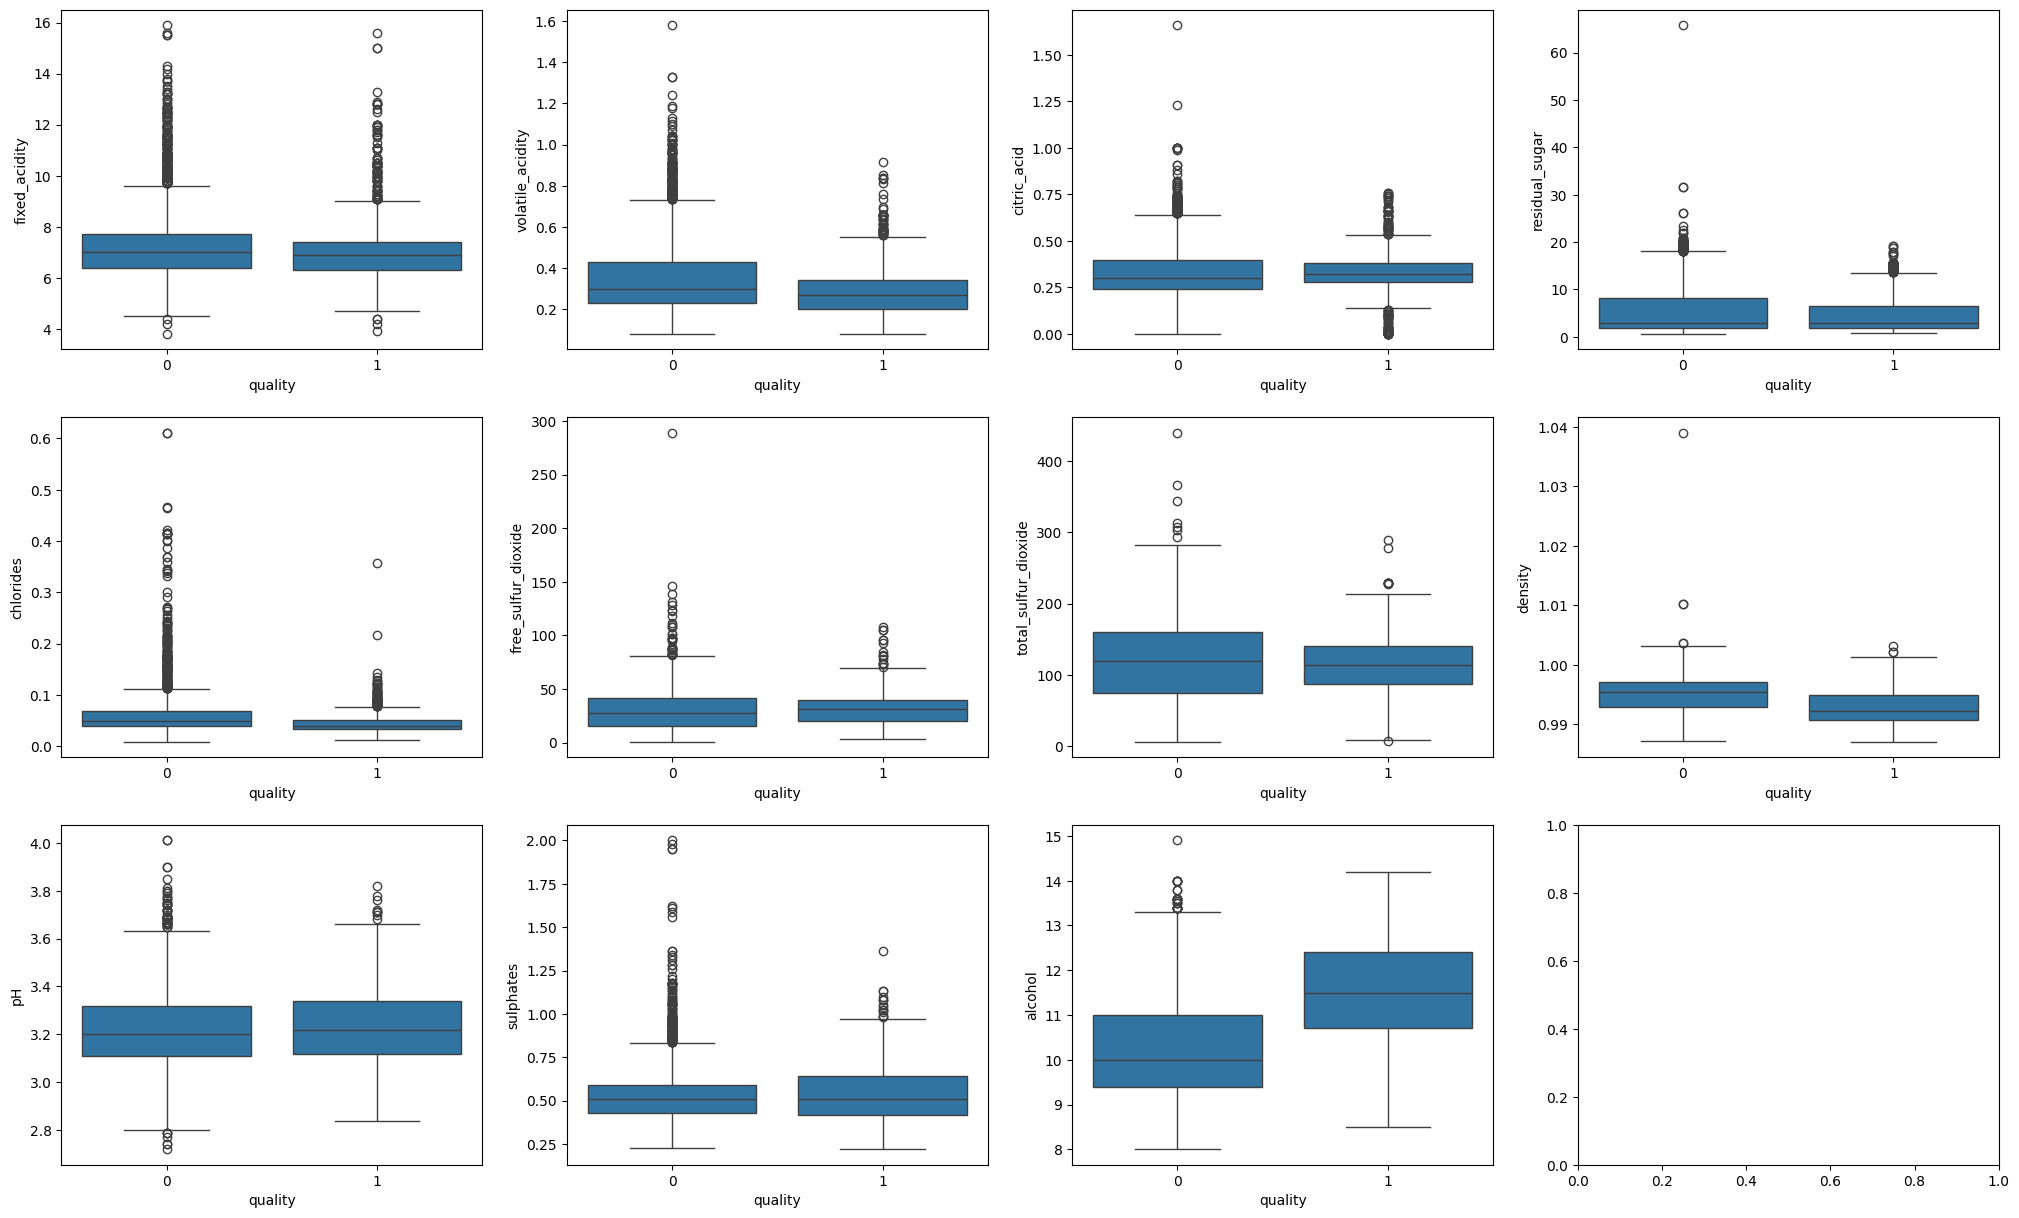

In [7]:
import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In the above box plots, a few variables stand out as good univariate predictors of quality.

- In the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
- In the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.

## Preprocess data
Before training a model, check for missing values and split the data into training and validation sets.

In [8]:
data.isna().any()

fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
is_red                  False
dtype: bool

There are no missing values.

## Prepare the dataset to train a baseline model
Split the input data into 3 sets:

- Train (60% of the dataset used to train the model)
- Validation (20% of the dataset used to tune the hyperparameters)
- Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

In [9]:
from sklearn.model_selection import train_test_split

X = data.drop(["quality"], axis=1)
y = data.quality

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)

# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

## Define an MLflow Experiment

In order to group any distinct runs of a particular project or idea together, we can define an Experiment that will group each iteration (runs) together. 
Defining a unique name that is relevant to what we're working on helps with organization and reduces the amount of work (searching) to find our runs later on. 

In [10]:
mlflow.create_experiment("Hyperparameter Tuning")
mlflow.set_experiment("Hyperparameter Tuning")

<Experiment: artifact_location='mlflow-artifacts:/340538676486854572', creation_time=1730386256304, experiment_id='340538676486854572', last_update_time=1730386256304, lifecycle_stage='active', name='Hyperparameter Tuning', tags={}>

## Train a baseline model
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

Build a simple classifier using scikit-learn and use MLflow to keep track of the model's accuracy, and to save the model for later use.

In [11]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time

# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)

  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/10/31 18:51:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run untuned_random_forest at: http://10.164.4.28:5000/#/experiments/340538676486854572/runs/14e72209e79741939c96a641921469d0.
2024/10/31 18:51:01 INFO 

Review the learned feature importances output by the model. As illustrated by the previous boxplots, alcohol and density are important in predicting quality.

In [15]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

,importance
alcohol,0.259502
volatile_acidity,0.098425
sulphates,0.080500
chlorides,0.078191
free_sulfur_dioxide,0.077822
total_sulfur_dioxide,0.076367
density,0.067877
pH,0.067746
citric_acid,0.066116
residual_sugar,0.062659


## Experiment with a new model
The random forest model performed well even without hyperparameter tuning.

Use the xgboost library to train a more accurate model. Run a hyperparameter sweep to train multiple models in parallel, using Hyperopt and SparkTrials. As before, MLflow tracks the performance of each parameter configuration.

In [12]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
import mlflow.xgboost
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature

def create_search_space():
    return {
        'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
        'learning_rate': hp.loguniform('learning_rate', -3, 0),
        'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
        'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
        'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',  # Fixed metric format
        'seed': 123
    }

def train_model(params):
    # Ensure params are in correct format
    params = {k: float(v) if isinstance(v, np.float64) else v for k, v in params.items()}
    params['max_depth'] = int(params['max_depth'])
    
    mlflow.xgboost.autolog(log_model_signatures=True,
                          log_models=True,
                          log_input_examples=True)
    
    with mlflow.start_run(nested=True):
        # Create DMatrix objects
        train = xgb.DMatrix(data=X_train, label=y_train)
        validation = xgb.DMatrix(data=X_val, label=y_val)
        
        # Create evaluation list
        evals = [(train, 'train'), (validation, 'valid')]
        
        # Train model
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=evals,
            early_stopping_rounds=50,
            verbose_eval=100  # Print every 100 iterations
        )
        
        # Calculate metrics
        validation_predictions = booster.predict(validation)
        auc_score = roc_auc_score(y_val, validation_predictions)
        
        # Log metrics
        mlflow.log_metric('auc_score', auc_score)
        
        # Filter and log parameters (excluding None values)
        filtered_params = {k: v for k, v in params.items() if v is not None}
        mlflow.log_params(filtered_params)
        
        # Log model
        signature = infer_signature(X_train, booster.predict(train))
        mlflow.xgboost.log_model(booster, 
                                "model", 
                                signature=signature)
        
        return {
            'status': STATUS_OK,
            'loss': -1 * auc_score,
            'booster': booster.attributes()
        }

# Initialize trials
trials = Trials()

# Run optimization
with mlflow.start_run(run_name='xgboost_hyperparameter_tuning') as run:
    best_params = fmin(
        fn=train_model,
        space=create_search_space(),
        algo=tpe.suggest,
        max_evals=5,
        trials=trials
    )

    # Log best results
    mlflow.log_params(best_params)
    best_auc = -min([t['result']['loss'] for t in trials.trials])
    mlflow.log_metric('best_auc', best_auc)

# Print results
print("\nBest parameters found:")
for param, value in best_params.items():
    if param == 'max_depth':
        print(f"{param}: {int(value)}")
    else:
        print(f"{param}: {value}")

print(f"\nBest AUC: {best_auc:.4f}")

[0]	train-logloss:0.38451	valid-logloss:0.41995                                                                                                    
[68]	train-logloss:0.03107	valid-logloss:0.35446                                                                                                   
  0%|                                                                                                        | 0/5 [00:01<?, ?trial/s, best loss=?]

2024/10/31 18:51:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/10/31 18:51:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Giorgi\Desktop\MLflow_tut

C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:51:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-

[0]	train-logloss:0.32269	valid-logloss:0.40729                                                                                                    
[60]	train-logloss:0.01399	valid-logloss:0.41333                                                                                                   
 20%|███████████████▍                                                             | 1/5 [00:16<01:00, 15.15s/trial, best loss: -0.8874363079386092]

2024/10/31 18:51:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/10/31 18:51:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Giorgi\Desktop\MLflow_tut

C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:51:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-

[0]	train-logloss:0.36461	valid-logloss:0.41116                                                                                                    
[61]	train-logloss:0.02352	valid-logloss:0.36810                                                                                                   
 40%|██████████████████████████████▊                                              | 2/5 [00:26<00:37, 12.44s/trial, best loss: -0.8874363079386092]

2024/10/31 18:51:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/10/31 18:51:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Giorgi\Desktop\MLflow_tut

C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-

[0]	train-logloss:0.24559	valid-logloss:0.40538                                                                                                    
[51]	train-logloss:0.00400	valid-logloss:0.44822                                                                                                   
 60%|██████████████████████████████████████████████▏                              | 3/5 [00:37<00:23, 11.76s/trial, best loss: -0.8874363079386092]

2024/10/31 18:51:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/10/31 18:51:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Giorgi\Desktop\MLflow_tut

C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:51:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-

[0]	train-logloss:0.48118	valid-logloss:0.47535                                                                                                    
[100]	train-logloss:0.21876	valid-logloss:0.33173                                                                                                  
[200]	train-logloss:0.16053	valid-logloss:0.32271                                                                                                  
[300]	train-logloss:0.12464	valid-logloss:0.31857                                                                                                  
[340]	train-logloss:0.11504	valid-logloss:0.31827                                                                                                  
 80%|█████████████████████████████████████████████████████████████▌               | 4/5 [00:49<00:11, 11.52s/trial, best loss: -0.8894490540478133]

2024/10/31 18:51:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

2024/10/31 18:51:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Giorgi\Desktop\MLflow_tut

C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(

C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:51:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-

100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.07s/trial, best loss: -0.8894490540478133]

2024/10/31 18:52:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run xgboost_hyperparameter_tuning at: http://10.164.4.28:5000/#/experiments/340538676486854572/runs/1bada1d32e364a9f8c6c782db4018f22.
2024/10/31 18:52:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://10.164.4.28:5000/#/experiments/340538676486854572.




Best parameters found:
learning_rate: 0.5665247506903418
max_depth: 26
min_child_weight: 0.6532347327754694
reg_alpha: 0.016810674119850842
reg_lambda: 0.005031590086671324

Best AUC: 0.8894


## Log and register model with selected parameters

In [13]:
import mlflow
import mlflow.xgboost
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Assuming best_params, X_train, y_train, X_test, and y_test are defined

with mlflow.start_run(run_name="Final_Model"):
    best_params['max_depth'] = int(best_params['max_depth'])
    
    # Create and fit the model
    model = xgb.XGBClassifier(**best_params)
    model.fit(X_train, y_train)

    # Log model parameters
    for param, value in best_params.items():
        mlflow.log_param(param, value)

    # Log the model
    mlflow.xgboost.log_model(model, "model")

    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class

    # Calculate and log AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    mlflow.log_metric("auc", auc)

    # Register the model
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    mlflow.register_model(model_uri=model_uri, name="XGBoostModel")

print("Model logged and registered with MLflow, including AUC.")


2024/10/31 18:52:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/10/31 18:52:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Giorgi\Desktop\MLflow_tuto

C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:52:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/10/31 18:52:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/31 18:52:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Giorgi\Desktop\MLflow_tutorial\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it 

Model logged and registered with MLflow, including AUC.


## Using code in the following cell we can also download the model

In [14]:
# Define the model name
model_name = "XGBoostModel"

# Create an MLflow client
client = mlflow.tracking.MlflowClient()

# Get all the versions of the registered model and select the latest version
versions = client.get_registered_model(name=model_name).latest_versions
latest_version = max([int(version.version) for version in versions])
print(f"Latest version: {latest_version}")

# Construct the model URI for the latest version
model_uri = f"models:/{model_name}/{latest_version}"

# Define the path where the model will be downloaded
download_path = "./downloaded_model"

# Download the model artifacts
mlflow.artifacts.download_artifacts(artifact_uri=model_uri, dst_path=download_path)

print(f"Model downloaded to {download_path}")

Latest version: 1


Model downloaded to ./downloaded_model
